# 🏠 Sarajevo Flats Scraper
This notebook demonstrates how to collect real estate data (flats in Sarajevo Canton) from **OLX.ba**, a popular Bosnian classifieds platform.

The goal is to:
- Collect key property details (title, price, size, location, condition…)
- Store them in a structured dataset (`sarajevo_flats.csv`)
- Prepare the dataset for future analysis or machine learning (e.g. AI price estimation)

We'll use **Selenium** for dynamic page loading and **BeautifulSoup** for parsing HTML.


In [1]:
import os
import time
import csv
import re
import random
from urllib.parse import urljoin
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.firefox.service import Service
from selenium.common.exceptions import WebDriverException, TimeoutException

In [2]:
# Firefox + Geckodriver setup
firefox_binary = "/usr/bin/firefox"
geckodriver_binary = "/home/mustafasinanovic/miniforge3/bin/geckodriver"

# Scraper settings
BASE_URL = "https://olx.ba/pretraga?attr=&attr_encoded=1&q=stanovi&category_id=23&page={}&canton=9"
OUTPUT_CSV = "data/sarajevo_flats.csv"
MAX_PAGES = 50
REQUEST_DELAY = (2, 5)

os.makedirs("data", exist_ok=True)

The scraper will fetch up to 50 pages of listings from the OLX search results for *Sarajevo Canton flats*.  
All results are stored in `data/sarajevo_flats.csv`.  
We use randomized delays between requests to reduce the risk of blocking.

In [3]:
def clean_text(s):
    return " ".join(s.split()).strip() if s else None

def extract_price(text):
    if not text:
        return None
    cleaned = re.sub(r"[^0-9]", "", text)
    return int(cleaned) if cleaned else None

def extract_number(text):
    if not text:
        return None
    m = re.search(r"(\d+)", text)
    return int(m.group(1)) if m else None

---

#### 1️⃣ `clean_text(s)`

```python
def clean_text(s):
    return " ".join(s.split()).strip() if s else None
````

**Purpose:**
Cleans messy text by removing extra spaces and newlines.

**How it works:**

* Splits the string into words using `.split()` (automatically handles multiple spaces).
* Joins them back into a single string with a single space between each word.
* Strips leading and trailing spaces.
* Returns `None` if the input is empty.

**Example:**

```python
clean_text("  Spacious   apartment   in   city center  ")
# Output: 'Spacious apartment in city center'
```

---

#### 2️⃣ `extract_price(text)`

```python
def extract_price(text):
    if not text:
        return None
    cleaned = re.sub(r"[^0-9]", "", text)
    return int(cleaned) if cleaned else None
```

**Purpose:**
Extracts numeric price values from strings (e.g. “250,000 KM” → 250000).

**How it works:**

* Removes all characters except digits using a regular expression (`[^0-9]`).
* Converts the remaining digits to an integer.
* Returns `None` if there’s no number found.

**Example:**

```python
extract_price("Cijena: 150,000 KM")
# Output: 150000
```

---

#### 3️⃣ `extract_number(text)`

```python
def extract_number(text):
    if not text:
        return None
    m = re.search(r"(\d+)", text)
    return int(m.group(1)) if m else None
```

**Purpose:**
Extracts the **first numeric value** from a string (useful for things like area, number of rooms, etc.).

**How it works:**

* Uses `re.search()` to find the first sequence of digits in the text.
* Converts it to an integer and returns it.
* Returns `None` if no digits are found.

**Example:**

```python
extract_number("Stan ima 3 sobe i 2 kupatila")
# Output: 3
```

In [4]:
def fetch_page_source(url, driver):
    """Loads a given URL and returns its HTML source, with timeout handling."""
    try:
        driver.get(url)
        time.sleep(3)
        return driver.page_source
    except (TimeoutException, WebDriverException, OSError) as e:
        print(f"[!] Failed to load page: {url} → {e}")
        return None
    except Exception as e:
        print(f"[!] Unexpected error loading page: {url} → {e}")
        return None

This function uses Selenium to load pages dynamically.
If a page fails (timeout, network error, etc.), we log the issue but continue scraping.

In [5]:
def parse_detail_page(url, driver):
    html = fetch_page_source(url, driver)
    if not html:
        return None

    try:
        soup = BeautifulSoup(html, "lxml")
        get_text = lambda sel: clean_text(soup.select_one(sel).get_text()) if soup.select_one(sel) else None

        title = get_text("h1") or get_text(".main-title-listing")
        price_numeric = extract_price(get_text(".price-heading"))

        municipality_tag = soup.find("div", class_="btn-pill city")
        if municipality_tag:
            for svg in municipality_tag.find_all("svg"):
                svg.decompose()
            municipality = clean_text(municipality_tag.get_text())
        else:
            municipality = None

        rooms = extract_number(get_text("div.required-wrap:nth-child(5) > div:nth-child(2) > h4:nth-child(2)"))
        square_m2_text = get_text("div.required-wrap:nth-child(6) > div:nth-child(2) > h4:nth-child(2)")
        try:
            square_m2 = float(square_m2_text.replace(",", ".")) if square_m2_text else None
        except:
            square_m2 = None

        details = {
            "title": title,
            "url": url,
            "price_numeric": price_numeric,
            "municipality": municipality,
            "condition": get_text("div.required-wrap:nth-child(2) > div:nth-child(2) > h4:nth-child(2)"),
            "ad_type": get_text("div.required-wrap:nth-child(3) > div:nth-child(2) > h4:nth-child(2)"),
            "property_type": get_text("div.required-wrap:nth-child(4) > div:nth-child(2) > h4:nth-child(2)"),
            "rooms": rooms,
            "square_m2": square_m2,
            "equipment": get_text("div.required-wrap:nth-child(7) > div:nth-child(2) > h4:nth-child(2)"),
            "level": get_text("div.required-wrap:nth-child(8) > div:nth-child(2) > h4:nth-child(2)"),
            "heating": get_text("div.required-wrap:nth-child(9) > div:nth-child(2) > h4:nth-child(2)")
        }

        print("Parsed:", details)
        return details
    except Exception as e:
        print(f"[!] Failed to parse details for {url} → {e}")
        return None


---

### 🏠 `parse_detail_page(url, driver)` — Parsing Flat Details from Listing Pages

This function extracts detailed information about a **single flat listing** (e.g. on OLX or similar platforms) using Selenium and BeautifulSoup.

---

#### 🧩 Step-by-Step Explanation

```python
def parse_detail_page(url, driver):
    html = fetch_page_source(url, driver)
    if not html:
        return None
```

* Loads the HTML content of a property listing using a Selenium driver.
* If the page cannot be loaded, returns `None`.


```python
soup = BeautifulSoup(html, "lxml")
get_text = lambda sel: clean_text(soup.select_one(sel).get_text()) if soup.select_one(sel) else None
```

* Parses the HTML with **BeautifulSoup** using the fast `lxml` parser.
* Defines a helper lambda `get_text()` to easily extract and clean text from a given CSS selector.

---

```python
title = get_text("h1") or get_text(".main-title-listing")
price_numeric = extract_price(get_text(".price-heading"))
```

* Extracts the **listing title** and **price** (converted into an integer) from the page.

---

```python
municipality_tag = soup.find("div", class_="btn-pill city")
...
municipality = clean_text(municipality_tag.get_text())
```

* Finds the **municipality** (city area) by looking for the `div` with class `btn-pill city`.
* Removes any `<svg>` icons inside it to get clean text.

---

```python
rooms = extract_number(get_text("div.required-wrap:nth-child(5) > div:nth-child(2) > h4:nth-child(2)"))
square_m2_text = get_text("div.required-wrap:nth-child(6) > div:nth-child(2) > h4:nth-child(2)")
```

* Extracts the **number of rooms** and **apartment size in m²**.
* Converts the size from a text format (e.g. `"65,5"`) into a float.

---

#### 🧾 The Final `details` Dictionary

All collected attributes are stored in a dictionary:

```python
details = {
    "title": title,
    "url": url,
    "price_numeric": price_numeric,
    "municipality": municipality,
    "condition": ...,
    "ad_type": ...,
    "property_type": ...,
    "rooms": rooms,
    "square_m2": square_m2,
    "equipment": ...,
    "level": ...,
    "heating": ...
}
```

Each field corresponds to a key property of the apartment listing — making it easy to later convert into a Pandas DataFrame or CSV file.

---

#### ⚙️ Error Handling

If any part of the parsing fails, the function prints an error message with the problematic URL and returns `None`:

```python
except Exception as e:
    print(f"[!] Failed to parse details for {url} → {e}")
```

In [6]:
def scrape():
    options = Options()
    options.binary_location = firefox_binary
    options.add_argument("--headless")
    service = Service(executable_path=geckodriver_binary)
    driver = webdriver.Firefox(service=service, options=options)
    driver.set_page_load_timeout(120)

    fieldnames = ["title","url","price_numeric","municipality",
                  "condition","ad_type","property_type","rooms","square_m2","equipment","level","heating"]

    write_header = not os.path.exists(OUTPUT_CSV)
    with open(OUTPUT_CSV, "a", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if write_header:
            writer.writeheader()

        for page in range(1, MAX_PAGES + 1):
            search_url = BASE_URL.format(page)
            html = fetch_page_source(search_url, driver)
            if not html:
                print(f"[!] Skipping search page {page}")
                continue

            try:
                soup = BeautifulSoup(html, "lxml")
                main_section = soup.find("main", class_="articles")
                if not main_section:
                    continue

                links = [urljoin("https://olx.ba", a["href"]) for a in main_section.find_all("a", href=True)]
                print(f"Page {page}: found {len(links)} listings")

                for link in links:
                    try:
                        data = parse_detail_page(link, driver)
                        if data:
                            writer.writerow(data)
                        time.sleep(random.uniform(*REQUEST_DELAY))
                    except Exception as e:
                        print(f"[!] Skipping listing {link} due to error → {e}")
            except Exception as e:
                print(f"[!] Failed to parse search page {page} → {e}")

    driver.quit()
    print(f"Finished. CSV saved at: {OUTPUT_CSV}")


### 🕸️ `scrape()` — Main Scraper Function for OLX Flat Listings

This is the **main control function** that automates the entire data collection process:
it configures the browser, navigates through search pages, extracts listing details,
and saves them into a CSV file.

---

#### ⚙️ Step 1: Configure the Firefox WebDriver

```python
options = Options()
options.binary_location = firefox_binary
options.add_argument("--headless")
service = Service(executable_path=geckodriver_binary)
driver = webdriver.Firefox(service=service, options=options)
driver.set_page_load_timeout(120)
````

* Sets up **Firefox in headless mode** (no visible browser window).
* Uses the pre-defined paths for the Firefox binary and `geckodriver`.
* A **page load timeout** of 120 seconds prevents the scraper from hanging indefinitely.

This allows the script to load dynamic pages from OLX efficiently using Selenium.

---

#### 📄 Step 2: Prepare the CSV File

```python
fieldnames = ["title","url","price_numeric","municipality",
              "condition","ad_type","property_type","rooms","square_m2","equipment","level","heating"]

write_header = not os.path.exists(OUTPUT_CSV)
with open(OUTPUT_CSV, "a", newline="", encoding="utf-8") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    if write_header:
        writer.writeheader()
```

* Defines the column names that match the fields extracted by `parse_detail_page()`.
* Checks whether the output CSV already exists — if not, it writes a **header row**.
* Opens the CSV file in **append mode**, so the scraper can continue from previous runs without overwriting existing data.

---

#### 🔎 Step 3: Iterate Through Search Pages

```python
for page in range(1, MAX_PAGES + 1):
    search_url = BASE_URL.format(page)
    html = fetch_page_source(search_url, driver)
```

* Loops over multiple search result pages (e.g. page 1, 2, 3, ...).
* Dynamically inserts the page number into the base URL template.
* Uses `fetch_page_source()` to load each page and get its HTML.

If the page fails to load, it prints a warning and skips to the next one.

---

#### 🧩 Step 4: Extract All Listing Links

```python
soup = BeautifulSoup(html, "lxml")
main_section = soup.find("main", class_="articles")
links = [urljoin("https://olx.ba", a["href"]) for a in main_section.find_all("a", href=True)]
```

* Parses the page using BeautifulSoup to locate the main listings section.
* Collects all the **individual listing URLs**.
* Prepends the base domain (`https://olx.ba`) to each relative link to get full URLs.

---

#### 🏠 Step 5: Parse Each Listing and Save the Data

```python
for link in links:
    data = parse_detail_page(link, driver)
    if data:
        writer.writerow(data)
    time.sleep(random.uniform(*REQUEST_DELAY))
```

* Visits each listing one by one.
* Calls the previously defined `parse_detail_page()` to extract detailed information.
* If valid data is returned, writes it as a new row in the CSV file.
* Adds a **random delay** between requests to avoid being blocked by the site.

---

#### 🧯 Step 6: Handle Errors Gracefully

If any listing or page causes an error (timeout, missing element, etc.),
the function catches the exception, logs it, and **continues scraping** instead of stopping.

```python
except Exception as e:
    print(f"[!] Skipping listing {link} due to error → {e}")
```

This ensures that a few broken pages don’t interrupt the entire process.

---

#### ✅ Step 7: Close the Browser and Finish

```python
driver.quit()
print(f"Finished. CSV saved at: {OUTPUT_CSV}")
```

* After all pages are processed, the Selenium WebDriver is closed.
* A success message confirms the output file location.

In [7]:
if __name__ == "__main__":
    scrape()

KeyboardInterrupt: 

In [ ]:
import pandas as pd

# --- Load both datasets ---
df1 = pd.read_csv("data/sarajevo_flats_1.csv")
df2 = pd.read_csv("data/sarajevo_flats_2.csv")

print(f"First dataset: {df1.shape[0]} rows")
print(f"Second dataset: {df2.shape[0]} rows")

# --- Combine them ---
combined_df = pd.concat([df1, df2], ignore_index=True)

print(f"Combined before removing duplicates: {combined_df.shape[0]} rows")

# --- Remove duplicates ---
# We'll use the 'url' field as the unique identifier (you can change this if needed)
combined_df.drop_duplicates(subset="url", inplace=True)

print(f"After removing duplicates: {combined_df.shape[0]} rows")

# --- Optional: sort by price or area for consistency ---
combined_df.sort_values(by=["price_numeric"], ascending=True, inplace=True)

# --- Save merged dataset ---
combined_df.to_csv("data/sarajevo_flats_merged.csv", index=False)

print("✅ Merged dataset saved as 'data/sarajevo_flats_merged.csv'")

# --- Preview final dataset ---
combined_df.head()

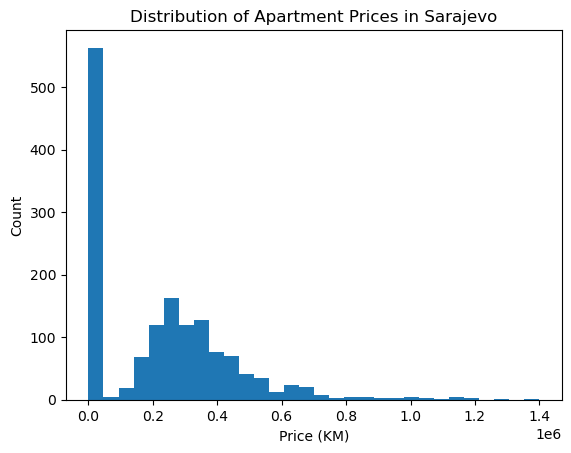

In [3]:
import matplotlib.pyplot as plt

plt.hist(combined_df["price_numeric"].dropna(), bins=30)
plt.title("Distribution of Apartment Prices in Sarajevo")
plt.xlabel("Price (KM)")
plt.ylabel("Count")
plt.show()